In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
'''
Script to train an object recognition model. 

'''


import argparse
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt



from datetime import datetime
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC

In [3]:
#Helper function to load and process dataset
def load_dataset(data_filename, keys=None):
     ''' assume all datasets are numpy arrays '''
     import h5py
     dataset = {}
     with h5py.File(data_filename, 'r') as hf:
        if keys is None:
             for name in hf:
                #print(name)
                dataset[name] = np.array(hf.get(name))
        else:
             for name in keys:
                dataset[name] = np.array(hf.get(name))
     return dataset

In [4]:
#Helper function to create model
def get_model(model, num_classes, method='top', shape=(320,320,1)):
    ''' based on the type of model, load and prep model '''
    # TODO add param for fine tuning layers
    if model == 'inception':
        from tensorflow.keras.applications.inception_v3 import InceptionV3
        # create the base pre-trained model
        base_model = InceptionV3(weights='imagenet', include_top=False)
    elif model=='resnet':
        from tensorflow.keras.applications.resnet50 import ResNet50
        base_model = ResNet50(weights='imagenet', include_top=False)
    elif model == 'dense':
        from tensorflow.keras.applications import DenseNet121
        base_model = DenseNet121(weights='imagenet', include_top=False)
    elif model == 'vgg':
        from tensorflow.keras.applications import VGG16
        base_model = VGG16(weights='imagenet', include_top=False)
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(num_classes, activation='softmax')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    if method == 'top':
        for layer in base_model.layers:
            layer.trainable = False
    elif method == 'all':
        # make all layers trainable
        for layer in model.layers:
            layer.trainable = True
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


    

In [5]:
# get data
tf.keras.backend.clear_session()

data = load_dataset('/content/gdrive/Shareddrives/CS 6604 Project/Dataset/object_rec_dataset.h5') #load dataset from give file
#seperate into clean data, labels and poisoned data
#poisoned labels are created manually
clean_data = data['clean_data']
clean_labels = data['clean_labels']
trig_data = data['poison_data']




In [6]:
#info about data
#index 0 = backpack
#index 1 = cell phone
#index 2 = coffee mug
#index 3 = laptop
#index 4 = purse
#index 5 = running shoe
#index 6 = sunglasses
#index 7 = tennis ball
#index 8 = water bottle

In [7]:
#target label number that will be the 
#number coorelates to index value above

labelnum = 5 

#update this value to change trigger classifier to a different object

In [8]:
# BACKDOOR ATTACK MODEL IMPLEMENTATION

from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess

#processing image data
clean_data = np.array([preprocess(el) for el in clean_data])
trig_data = np.array([preprocess(el) for el in trig_data])

# split into train/test
x_train, x_test, y_train, y_test = train_test_split(clean_data, clean_labels, test_size=float(0.15), random_state=datetime.now().toordinal())

# get trig labels.
target_label = [0]*len(y_test[0])

target_label[labelnum] = 1
print(target_label)
trig_labels = list([target_label for i in range(len(trig_data))])
    
num_poison = int((len(x_train) * float(0.25)) / (1 - float(0.25))) + 1

    # Calculate what percent of the poison data this is.
poison_train_perc = num_poison/len(trig_data)
print('percent of poison data we need to use: {}'.format(poison_train_perc))
print('injection rate: {}'.format(num_poison/(len(x_train) + num_poison)))
    
    # take a random poison sample of this size from the poison data.     
x_poison_train, x_poison_test, y_poison_train, y_poison_test = train_test_split(trig_data, trig_labels, test_size=(1-poison_train_perc), random_state=datetime.now().toordinal())

    # stack for training
all_train_x = np.append(x_train, x_poison_train, axis=0)
all_train_y = np.append(y_train, y_poison_train, axis=0)
    
    # prep data generator
shift = 0.2
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, width_shift_range=shift,
                                       height_shift_range=shift, rotation_range=30,
                                       validation_split=0.1)
    
print(type(datagen))
datagen.fit(all_train_x)
    # split into training and validation datasets
train_datagen = datagen.flow(all_train_x, all_train_y,
                                 batch_size=16,
                                 subset='training')
validation_datagen = datagen.flow(all_train_x, all_train_y,
                                      batch_size=16,
                                      subset='validation')
    # get the model
shape = (224, 224, 3)
student_model = get_model('vgg', len(y_train[0]), shape=shape)

    #Training the model    
student_model.fit_generator(train_datagen,
                                     validation_data=validation_datagen,
                                     epochs=15, verbose=1)  

    # Test student model.
tcl, train_clean_acc = student_model.evaluate(np.array(x_train), np.array(y_train), verbose=1)
tscl, test_clean_acc = student_model.evaluate(np.array(x_test), np.array(y_test), verbose=1)
ttl, train_trig_acc = student_model.evaluate(np.array(x_poison_train), np.array(y_poison_train), verbose=1)
tstl, test_trig_acc = student_model.evaluate(np.array(x_poison_test), np.array(y_poison_test), verbose=1)



[0, 0, 0, 0, 0, 1, 0, 0, 0]
percent of poison data we need to use: 0.8181818181818182
injection rate: 0.25040916530278234
<class 'keras.preprocessing.image.ImageDataGenerator'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
69/69 [==============================] - 25s 309ms/step - loss: 1.4619 - accuracy: 0.7373 - val_loss: 0.8708 - val_accuracy: 0.8279
Epoch 2/15
69/69 [==============================] - 18s 259ms/step - loss: 0.3070 - accuracy: 0.9055 - val_loss: 1.4345 - val_accuracy: 0.7869
Epoch 3/15
69/69 [==============================] - 18s 261ms/step - loss: 0.3082 - accuracy: 0.9136 - val_loss: 0.8719 - val_accuracy: 0.8607
Epoch 4/15
69/69 [==============================] - 18s 262ms/step - loss: 0.2342 - accuracy: 0.9355 - val_loss: 1.0373 - val_accuracy: 0.8197
Epoch 5/15
69/69 [==============================] - 19s 271ms/step - loss: 0.1422 - accuracy: 0.9518 - val_loss: 0.6985 - val_accuracy: 0.8361
Epoch 6/15
69/69 [==============================] - 23s 335ms/step - loss: 0.1460 - accuracy: 0.9518 - val_loss: 1.3065 - val_accuracy: 0.7951
Epoch 7/15
69/69 [==============================] - 18s 261ms/step - loss: 0.1224 - accuracy: 0.9609 - val_loss: 0.9747 - val_accuracy: 0.8770

In [9]:
#Create directory path to save model
savestring = '/content/gdrive/Shareddrives/CS 6604 Project/clean_model_targetlabel' + str(labelnum)
print(savestring)

/content/gdrive/Shareddrives/CS 6604 Project/clean_model_targetlabel5


In [10]:
#Saves current model into our directory
student_model.save(savestring)

INFO:tensorflow:Assets written to: /content/gdrive/Shareddrives/CS 6604 Project/clean_model_targetlabel5/assets


In [11]:
from keras.saving import saved_model
from keras.models import load_model

#Reloads model for STRIP implementation based on given string
model = load_model(savestring) 

In [12]:
#Testing classification rate of clean inputs
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1) #Has a larger batch size
print("Testing target label: ", labelnum)

print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

2/2 [==============================] - 19s 5s/step - loss: 0.5969 - accuracy: 0.8889
Testing target label:  5

Test result: 88.889 loss: 0.597


In [13]:
#Testing attack success rate of trojaned inputs
y_pred=model.predict(x_poison_test)
c=0
print("Testing target label: ", labelnum)
for i in range(x_poison_test.shape[0]):
    if np.argmax(y_pred[i]) == labelnum: #labelnum = num of target label
        c=c+1
print("  ",c*100.0/x_poison_test.shape[0])

Testing target label:  5
   98.52941176470588


In [14]:
#These values control the blend ratio for superimposing. 
#Edit these values to change the blend ratio for the inputs, and rerun this cell 
#before running the STRIP code.

#Background_blend = Weight of the benign/trojan input
#Overlay_blend = Weight of the clean input superimposed with it

background_blend = 1
overlay_blend = 1

#Tested w/ values, 1, 0.5, 0.7, and 0.3

In [15]:
#STRIP CODE

import math
import random
import numpy as np
import time
import scipy
import cv2

photos = []
predictions = []

def superimpose(background, overlay): #blending function that needs to be changed/improve
  added_image = cv2.addWeighted(background,background_blend,overlay,overlay_blend,0)
  photos.append(added_image)
  return (added_image.reshape(added_image.shape[0],added_image.shape[0],3)) 

def entropyCal(background, n): #function to calculate entropy
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(733,915, size=n) 
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  predictions.append(py1_add)
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 300 # number of images being tested
n_sample = 15 #number of images being superimposed w/ image
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
blend_ratio = str(background_blend) + ":" + str(overlay_blend)
print("Testing Strip with "+blend_ratio+ " Ratio")

for j in range(n_test): #superimposing and calculating entropy w/ benign inputs 
  if 0 == j%150: 
    print(j)
  x_background = x_train[j] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test): #superimposing and calculating entropy w/ trojan inputs
  if 0 == j%150:
    print(j)
  x_poison = trig_data[j]
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 300 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 300 trojaned inputs

Testing Strip with 1:1 Ratio
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


150
0
150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9000
benigh


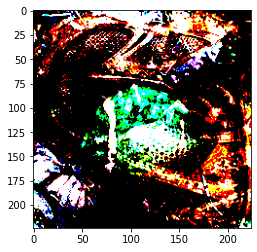

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


trojan


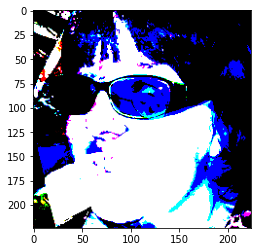

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


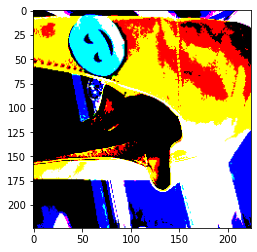

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


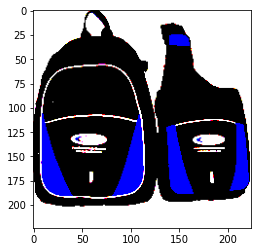

300


In [16]:
print(len(photos))
print("benigh")
plt.imshow(photos[368])
plt.show()

print("trojan")
plt.imshow(photos[7210])
plt.show()

plt.imshow(trig_data[200])
plt.show()

plt.imshow(x_train[222])
plt.show()

print(len(entropy_benigh))



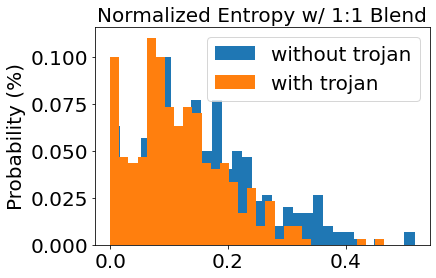

In [17]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
title = 'Normalized Entropy w/ ' +str(background_blend)+':'+str(overlay_blend)+ ' Blend'
plt.title(title, fontsize = 20)
plt.tick_params(labelsize=20)
#plt.ylim(0,1);

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

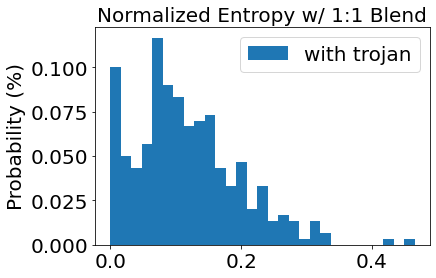

In [18]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
title = 'Normalized Entropy w/ ' +str(background_blend)+':'+str(overlay_blend)+ ' Blend'

plt.title(title, fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [19]:
import scipy
import scipy.stats
import pandas as pd

title = str(background_blend)+':'+str(overlay_blend)+ ' BLEND'

print("DATAFRAME FOR " + title)
print("Target label = ", labelnum)

FRR = [0.05, 0.07, 0.1,0.15, 0.2, 0.4, 0.8]

data = []

for r in FRR:
  (mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
  threshold = scipy.stats.norm.ppf(r, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
  #print("Threshold:",threshold) #detection boundary

  FAR = sum(i > threshold for i in entropy_trojan)/(300 * 15)*100
  #data.append([r, FAR, threshold])
  
  tp = 0 # trojan input is seen as trojan
  fn = 0 # benigh input is seen as trojan
  fp = 0 # trojan input is seen as clean
  tn = 0 # benigh input is seen as clean

  for i in range(len(entropy_trojan)):
    if entropy_trojan[i] <= threshold: #detected as trojaned
      tp = tp + 1 # trojan is seen as trojan
    else:
      fp = fp + 1 #trojan is seen as clean
  for i in range(len(entropy_benigh)):
    if entropy_benigh[i] <= threshold:
      fn = fn + 1 # seen as trojan
    else:
      tn = tn + 1 # seen as clean

  #print(tp,fn,fp,tn)
  value = 0
  value2 = 0
  if(tp+fn == 0):
    value = 300
  else:
    value = tp+fn
  if(fp+tn == 0):
    value2 = 300
  else:
    value2 = fp+tn

  tpr = (tp/(value))*100
  fpr = (fp/(value2))*100
  data.append([r, tpr, fpr, FAR, threshold])


# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'TP','FP','FAR', 'Threshold']) 
print(df)

DATAFRAME FOR 1:1 BLEND
Target label =  5
    FRR         TP         FP       FAR  Threshold
0  0.05   0.000000  50.000000  6.666667  -0.010085
1  0.07  60.000000  49.473684  6.266667   0.006985
2  0.10  66.129032  48.141264  5.755556   0.026597
3  0.15  62.626263  47.504990  5.288889   0.051346
4  0.20  59.589041  46.916300  4.733333   0.071016
5  0.40  57.055215  41.605839  2.533333   0.130413
6  0.80  52.952381  29.333333  0.488889   0.240970


In [20]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs


3.5881964625635495e-06
0.4649847666422526


In [21]:
#IGNORE ALL INFORMATION BELOW

In [ ]:
#link to how to visualize the images https://www.reddit.com/r/visualization/comments/eafyld/visualize_images_in_h5_files_in_python_for/